In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [2]:
# download the names.txt file from github
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

zsh:1: command not found: wget


In [3]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
itos = dict(enumerate(sorted(set("".join(words))), start=1))
itos[0] = "."
stoi = {v: k for k, v in itos.items()}

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
emb_dim = 10
# Embeddings
C = torch.randn((vocab_size, emb_dim), generator=g)
# First Hidden Layer
input_hidden1 = C.shape[1] * block_size,
output_hidden1 = 200
W1 = torch.randn((input_hidden1[0], output_hidden1), generator=g)
b1 = torch.randn(output_hidden1, generator=g)
# Output Layer
W2 = torch.randn((output_hidden1, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]


In [ ]:
# number of parameters in total
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters: 
    p.to(DEVICE)
    p.requires_grad = True

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200_000): 

    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass 
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, input_hidden1[0]) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # calculate the gradiants / backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()

    # update the weights 
    if i <= 90_000: 
        lr = 0.1
    elif i > 90_000 and i <= 150_000: 
        lr = 0.01
    else: 
        lr = 0.001
        
    for p in parameters: 
        p.data += -lr * p.grad

    # track stats 
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    if i % 10_000 == 0: 
        print(f"step: {i}/{200_000} - loss: {round(loss.item(),3)}")
        print("--------------------------------------")




step: 0/200000 - loss: 23.719
--------------------------------------
step: 10000/200000 - loss: 2.745
--------------------------------------
step: 20000/200000 - loss: 2.504
--------------------------------------
step: 30000/200000 - loss: 2.083
--------------------------------------
step: 40000/200000 - loss: 2.287
--------------------------------------
step: 50000/200000 - loss: 2.272
--------------------------------------
step: 60000/200000 - loss: 2.735
--------------------------------------
step: 70000/200000 - loss: 2.207
--------------------------------------
step: 80000/200000 - loss: 2.732
--------------------------------------
step: 90000/200000 - loss: 2.431
--------------------------------------
step: 100000/200000 - loss: 2.471
--------------------------------------
step: 110000/200000 - loss: 1.902
--------------------------------------
step: 120000/200000 - loss: 2.528
--------------------------------------
step: 130000/200000 - loss: 2.193
------------------------------

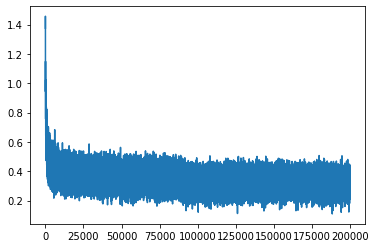

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss 
emb = C[Xtr] # (182625, 3, 10)
h = torch.tanh(emb.view(-1, input_hidden1[0]) @ W1 + b1) # (182625, 200)
logits = h @ W2 + b2 # (182625, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss)

tensor(2.1165, grad_fn=<NllLossBackward0>)


In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1492, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1516, grad_fn=<NllLossBackward0>)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out[:-1]))

carmah
amelle
khirmili
taty
skanden
jazhnen
delynn
jareei
nellara
chaiir
kaleigh
ham
joce
quint
shon
walianni
watelo
dearixit
kael
dura


In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# Parameters Initialization 

* What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 
* Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [ ]:
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
emb_dim = 10
# Embeddings
C = torch.randn((vocab_size, emb_dim), generator=g)
#C = torch.nn.init.uniform_(C)

# First Hidden Layer
input_hidden1 = C.shape[1] * block_size,
output_hidden1 = 200
W1 = torch.randn((input_hidden1[0], output_hidden1), generator=g)
b1 = torch.randn(output_hidden1, generator=g)
# Output Layer
W2 = torch.randn((output_hidden1, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters: 
    p = torch.nn.init.uniform_(p)
    p.to(DEVICE)
    p.requires_grad = True

In [ ]:
stepi, lossi = list(), list()

for i in range(200_000): 

    ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)

    emb = C[Xtr[ix]] # (182625, 3, 10)
    h = torch.tanh(emb.view(-1, input_hidden1[0]) @ W1 + b1) # (182625, 200)
    logits = h @ W2 + b2 # (182625, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters: 
        p.grad = None 
    loss.backward()

    # update the weights 
    if i <= 90_000: 
        lr = 0.1
    elif i > 90_000 and i <= 150_000: 
        lr = 0.01
    else: 
        lr = 0.001
        
    for p in parameters: 
        p.data += -lr * p.grad

    # track stats 
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    if i % 10_000 == 0: 
        print(f"step: {i}/{200_000} - loss: {round(loss.item(),3)}")
        print("--------------------------------------")


step: 0/200000 - loss: 11.87
--------------------------------------
step: 10000/200000 - loss: 3.409
--------------------------------------
step: 20000/200000 - loss: 3.669
--------------------------------------
step: 30000/200000 - loss: 4.396
--------------------------------------
step: 40000/200000 - loss: 4.8
--------------------------------------
step: 50000/200000 - loss: 3.813
--------------------------------------
step: 60000/200000 - loss: 3.213
--------------------------------------
step: 70000/200000 - loss: 2.722
--------------------------------------
step: 80000/200000 - loss: 3.458
--------------------------------------
step: 90000/200000 - loss: 3.048
--------------------------------------
step: 100000/200000 - loss: 2.628
--------------------------------------
step: 110000/200000 - loss: 3.117
--------------------------------------
step: 120000/200000 - loss: 2.788
--------------------------------------
step: 130000/200000 - loss: 2.779
---------------------------------